In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import scrublet as scr
import anndata
import scanpy.external as sce
import scvelo as scv
import infercnvpy as cnv
import os
import sklearn
import bbknn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

np.random.seed(0)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.8.0
scanpy      1.9.1
-----
Cython                                      0.29.28
OpenSSL                                     21.0.0
PIL                                         9.0.1
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
annoy                                       NA
asciitree                                   NA
asttokens                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
bbknn                                       NA
bcrypt                                      3.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
boto3                                       1.21.32
botocore                                    1.24.32
bottleneck                                  1.3.4
brotli                                      NA
cairo                                       1.21.0
certifi              

In [2]:
adata = sc.read_h5ad('./cache/scRNA_cnv.h5ad')

In [10]:
adata.obs['cell type'].value_counts()

T cell           22814
B cell            5999
Neutrophils       3191
NK cell           2469
Epithelial        2256
Monocytes         1637
Plasma cell       1093
Fibroblast         782
Endothelial        401
Proliferative      394
Mast cells         141
Name: cell type, dtype: int64

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:55)


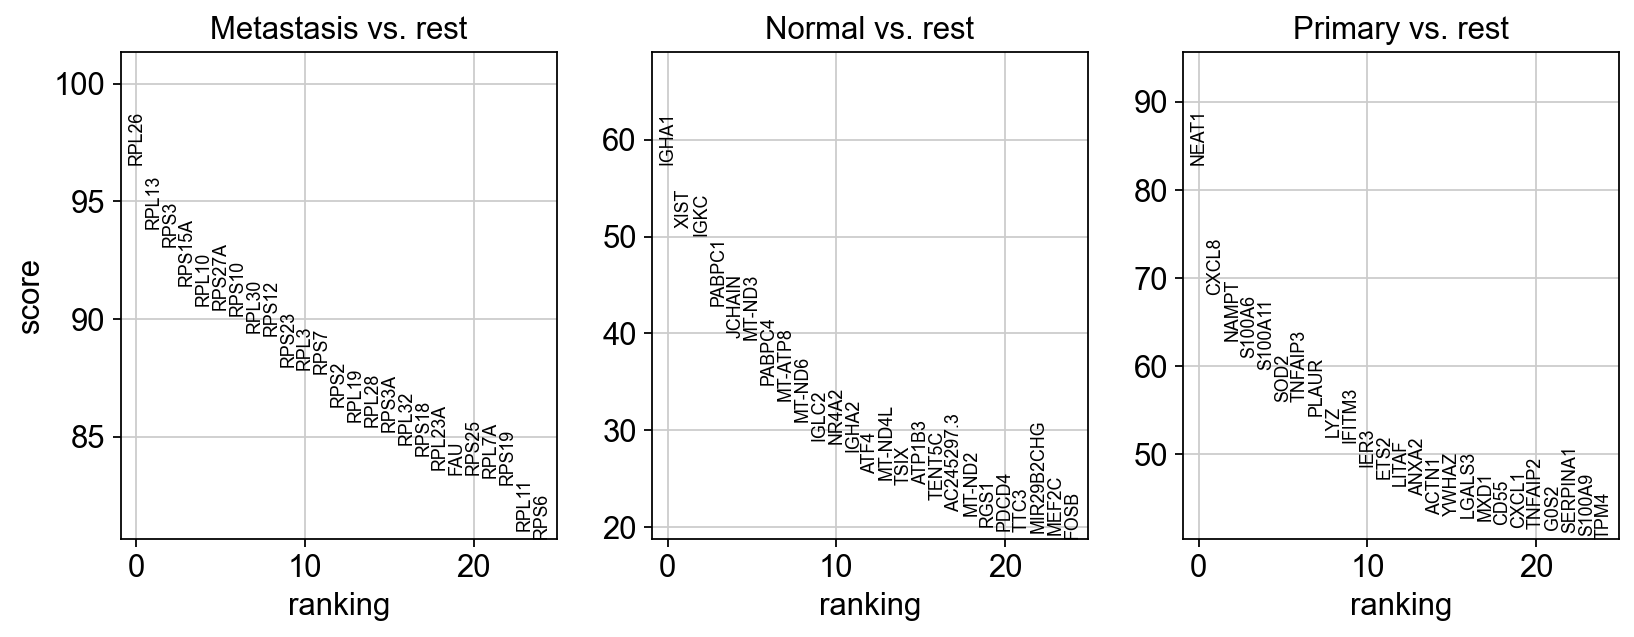

In [9]:
sc.tl.rank_genes_groups(adata,'metastasis_status',method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [11]:
Epithelial=adata[adata.obs['cell type'].isin(['Epithelial'])]
EPI=adata[adata.obs.index.isin(Epithelial.obs.index)]

In [13]:
EPI.obs['metastasis_status'].value_counts()

Primary       1916
Metastasis     202
Normal         138
Name: metastasis_status, dtype: int64

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


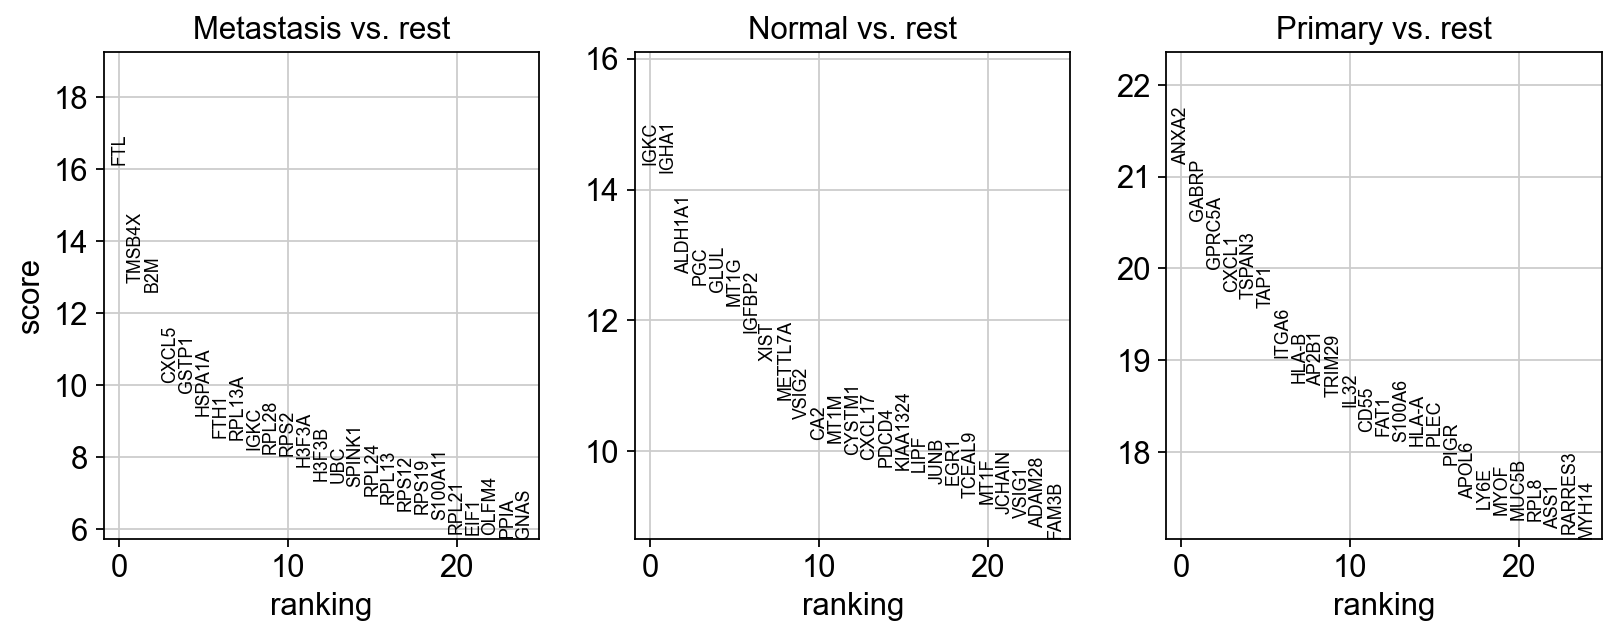

In [15]:
sc.tl.rank_genes_groups(EPI,'metastasis_status',method='wilcoxon')
sc.pl.rank_genes_groups(EPI, n_genes=25, sharey=False)

In [16]:
result =EPI.uns['rank_genes_groups']
groups = result['names'].dtype.names
res = pd.DataFrame(    {group + '_' + key: result[key][group]    for group in groups for key in ['names', 'pvals','logfoldchanges','pvals_adj','scores']})

In [17]:
res.to_csv("diff_EP1.csv")

In [18]:
EPI.obs

,n_genes,ID,Sample,Tissue,metastasis_status,percent_mito,batch,n_counts,log_counts,doublet_scores,...,cluster_1.1,cluster_1.2,cluster_1.3,cluster_1.4,cluster_1.5,barcode,cell type,cnv_leiden,cnv_score,cnv_status
AAAGGATCATGCCGAC-1,772,GSM5004180,PT1,Gastric,Primary,0.000000,0,1676.0,7.424165,0.339853,...,22,23,22,23,25,AAAGGATCATGCCGAC-1,Epithelial,0,0.006561,Normal
AACAACCAGTTCACTG-1,2119,GSM5004180,PT1,Gastric,Primary,0.009340,0,4925.0,8.502080,0.051351,...,22,23,22,23,25,AACAACCAGTTCACTG-1,Epithelial,2,0.023202,Malignant
AACGAAAAGCGCTGCT-1,1567,GSM5004180,PT1,Gastric,Primary,0.007949,0,3145.0,8.053569,0.039494,...,22,23,22,23,25,AACGAAAAGCGCTGCT-1,Epithelial,2,0.023202,Malignant
AAGATAGAGGTTGGAC-1,1965,GSM5004180,PT1,Gastric,Primary,0.002581,0,3875.0,8.262300,0.035159,...,22,23,22,23,25,AAGATAGAGGTTGGAC-1,Epithelial,2,0.023202,Malignant
AAGCATCGTACGCGTC-1,2800,GSM5004180,PT1,Gastric,Primary,0.000260,0,7694.0,8.948196,0.038005,...,22,23,22,23,25,AAGCATCGTACGCGTC-1,Epithelial,2,0.023202,Malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGTGTTAGTGTGCTTA-1,461,GSM5004189,Li2,Liver,Metastasis,0.000000,8,609.0,6.411819,0.104972,...,22,23,22,23,25,GGTGTTAGTGTGCTTA-1,Epithelial,0,0.006561,Normal
GTCTGTCAGGTGCTTT-1-1,359,GSM5004189,Li2,Liver,Metastasis,0.133690,8,561.0,6.329721,0.081081,...,22,23,22,23,25,GTCTGTCAGGTGCTTT-1-1,Epithelial,3,0.005482,Normal
GTGGAAGGTGTAAACA-1-1,337,GSM5004189,Li2,Liver,Metastasis,0.163188,8,527.0,6.267200,0.055283,...,22,23,22,23,25,GTGGAAGGTGTAAACA-1-1,Epithelial,2,0.023202,Malignant
GTGGTTATCGAGTACT-1,5264,GSM5004189,Li2,Liver,Metastasis,0.084038,8,19396.0,9.872822,0.147189,...,22,23,22,23,25,GTGGTTATCGAGTACT-1,Epithelial,2,0.023202,Malignant


In [19]:
EPI.obs['cnv_status'].value_counts()

Malignant    1802
Normal        454
Name: cnv_status, dtype: int64

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


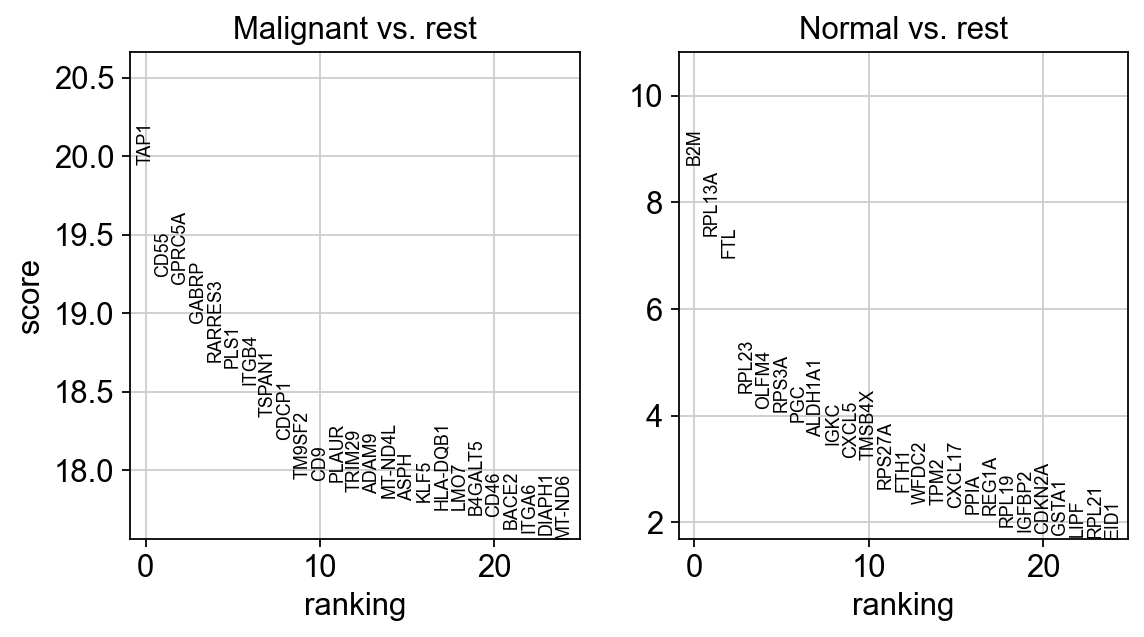

In [20]:
sc.tl.rank_genes_groups(EPI,'cnv_status',method='wilcoxon')
sc.pl.rank_genes_groups(EPI, n_genes=25, sharey=False)

In [21]:
result =EPI.uns['rank_genes_groups']
groups = result['names'].dtype.names
res = pd.DataFrame(    {group + '_' + key: result[key][group]    for group in groups for key in ['names', 'pvals','logfoldchanges','pvals_adj','scores']})

In [22]:
res.to_csv("diff_cnv.csv")